# L3-D - Linear Quantization II: Per Group Quantization

In this lesson, you will continue to learn about different granularities of performing linear quantization. You will cover `per group` in this notebook.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Linear Quantization II` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch

from helper import linear_q_symmetric_per_channel, get_q_scale_symmetric, linear_dequantization
from helper import plot_quantization_errors, quantization_error

## Different Granularities for Quantization
- For simplicity, you'll perform these using Symmetric mode.

### Per Group
- For simplicity, you'll quantize a 2D tensor along the rows.

In [2]:
def linear_q_symmetric_per_group(tensor, group_size,
                                 dtype=torch.int8):
    
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2
    
    tensor = tensor.view(-1, group_size)
    
    quantized_tensor, scale = linear_q_symmetric_per_channel(
                                tensor, dim=0, dtype=dtype)
    
    quantized_tensor = quantized_tensor.view(t_shape)
    
    return quantized_tensor, scale

In [3]:
def linear_dequantization_per_group(quantized_tensor, scale, 
                                    group_size):
    
    q_shape = quantized_tensor.shape
    quantized_tensor = quantized_tensor.view(-1, group_size)
    
    dequantized_tensor = linear_dequantization(quantized_tensor, 
                                               scale, 0)
    
    dequantized_tensor = dequantized_tensor.view(q_shape)
    
    return dequantized_tensor

In [41]:
n = 8
test_tensor = torch.rand((n, n))
group_size = 8

**Note:** Since the values are random, what you see in the video might be different than what you will get.

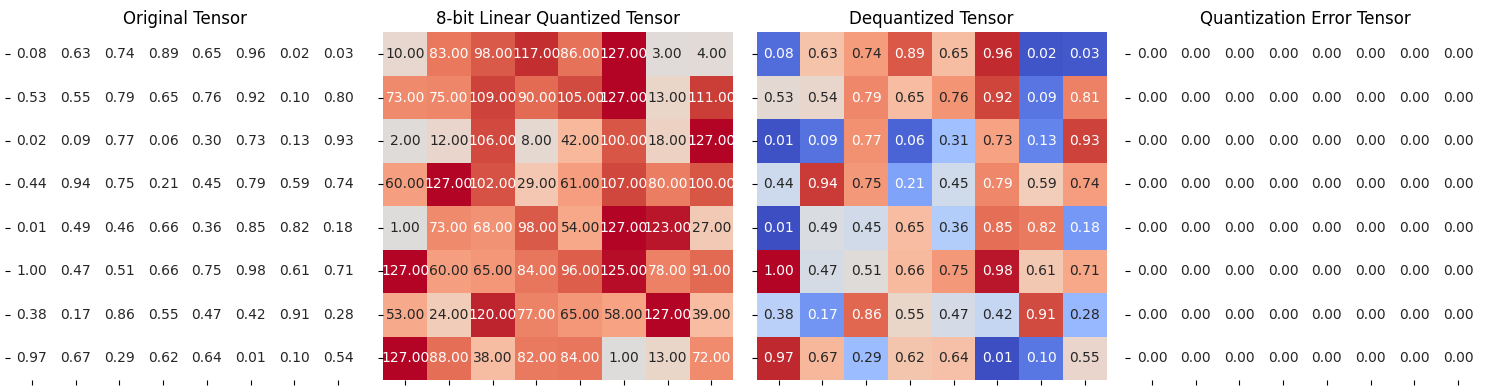

In [42]:
quantized_tensor, scale = linear_q_symmetric_per_group(
    test_tensor, group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(
    quantized_tensor, scale, group_size=group_size)

plot_quantization_errors(
    test_tensor, quantized_tensor, dequantized_tensor)

In [43]:
print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 3.334769871798926e-06


by increasing the number of elements in groups for quantization, we are loosing the preciseness, while gaining some mem/speed efficiency. by decreasing the number of elements in groups for quantization, we are gaining precision, while loosing some mem/speed efficiency

think about an extreme case. lets say we quantize the tensor for each group of size = 1. it means each number in the tensor would have its own [scale/zero]. Therefore, we can precisly recover the original value from the quantized matrix and the scale is equal to the ratio of real value to the max(quantization range). The problem here is we have the same number of scale as the number of elements in the matrix which does not make sense as we can skip doing the quantization and keep the original matrix as before. However, it is interesting to know that the error of quantization by having group size = 1 is 0, which means 100 percent accuracy on quant/dequant. This extreme example would be helpful to understand the trade-off between the group size / precisness / efficiency.